# Market Making with Reinforcement Learning

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Generic
from collections import defaultdict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym
from data.data_gen import DataGenerator

# Custom Modules
from Environment.market_making import MarketMakerEnv, PhiTransform

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Setup the training environment

In [2]:
lob_data = DataGenerator._generator('data/lob.csv', levels=1)
lob_data = lob_data.head(1200).values

In [21]:
# Create the environment
env = MarketMakerEnv(
    lob_data=lob_data,
    horizon=1000,
    phi_transorm=PhiTransform.PnL_asymm_dampened,
)
initial_state = env.reset()
display(initial_state)

array([ 2.23990000e+02,  1.00000000e+02,  2.23750000e+02,  7.40000000e+01,
        2.23870000e+02,  2.40000000e-01, -5.00000000e-03, -1.49425287e-01,
       -2.60000000e+01, -2.23338917e-05,  2.40100065e-05,  4.16666667e+01])

In [22]:
# Hyperparameters
alpha = 1e-3   # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration-exploitation trade-off
epsilon_decay = 0.995
min_epsilon = 0.01
episodes = 100  # Number of episodes

# Initialize the Q-table
q_table = defaultdict(lambda: np.zeros(9))

# Function to choose the next action
def choose_action(state):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(q_table[state])  # Exploit: select the action with max value

In [23]:
training_rewards = np.zeros(episodes)

# Training loop
for episode in tqdm(range(episodes)):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tuple = tuple(state)  # Convert the state to a tuple for Q-table indexing
        action = choose_action(state_tuple)
        next_state, reward, done, _ = env.step(action)
        next_state_tuple = tuple(next_state)
        
        # Q-learning update rule
        old_value = q_table[state_tuple][action]
        next_max = np.max(q_table[next_state_tuple])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state_tuple][action] = new_value
        
        state = next_state
        total_reward += reward
    
    # Decay epsilon for exploration-exploitation balance
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay
    
    # Print episode results
    if episode % 50 == 0 or episode == episodes - 1:
        print(f"Episode: {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    training_rewards[episode] = total_reward

print("Training completed.")

  0%|          | 0/100 [00:00<?, ?it/s]

Episode: 0, Total Reward: -211336.6799997793, Epsilon: 0.995
Episode: 50, Total Reward: -209322.6049997677, Epsilon: 0.7744209942832988
Episode: 99, Total Reward: -211074.94999975202, Epsilon: 0.6057704364907278
Training completed.


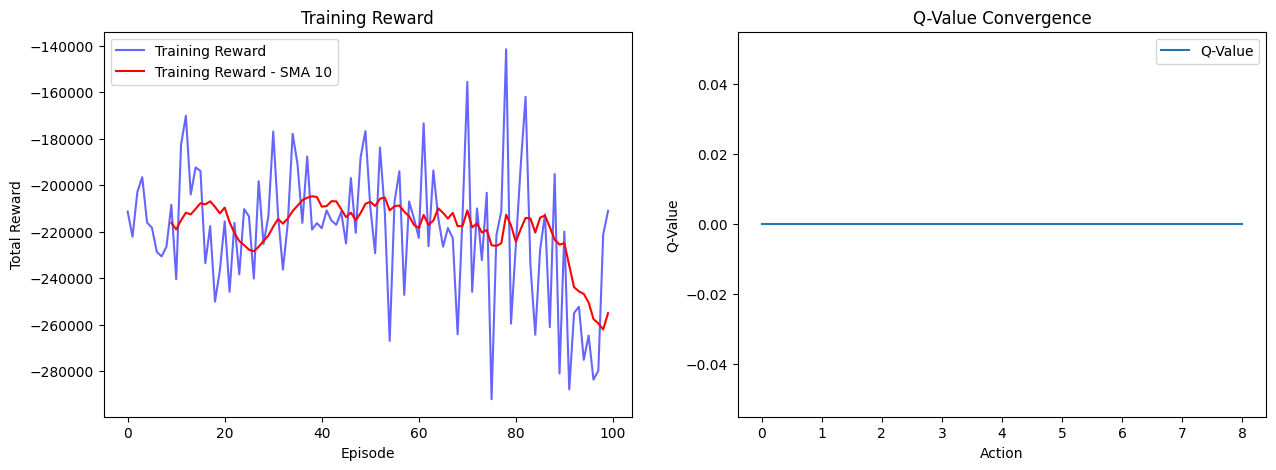

In [24]:
# Plot the training rewards and the convergence of the Q-values
SMA_WINDOW = 10
training_rewards_smoothed = pd.Series(training_rewards).rolling(SMA_WINDOW).mean()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(training_rewards, label="Training Reward", color="blue", alpha=0.6)
ax[0].plot(training_rewards_smoothed, label=f"Training Reward - SMA {SMA_WINDOW}", color="red")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Total Reward")
ax[0].set_title("Training Reward")
ax[0].legend()
# TODO
ax[1].plot(q_table[(0, 0, 0, 0, 0, 0, 0, 0, 0)], label="Q-Value")
ax[1].set_xlabel("Action")
ax[1].set_ylabel("Q-Value")
ax[1].set_title("Q-Value Convergence")
ax[1].legend()
plt.show()

In [25]:
print('Total orders placed', env.total_orders_placed)
print('Total orders executed', env.total_orders_executed)

Total orders placed 2000
Total orders executed 13612


## Testing

In [26]:
total_rewards = []
episodes = 50  # Number of episodes for testing

for episode in tqdm(range(episodes)):
    state = env.reset()
    done = False
    rewards = []
    
    while not done:
        action = np.argmax(q_table[tuple(state)])  # Choose the best action
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
    
    total_rewards.append(np.array(rewards))

total_rewards = np.array(total_rewards)

  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
print('Total orders placed', env.total_orders_placed)
print('Total orders executed', env.total_orders_executed)

Total orders placed 2000
Total orders executed 2142


In [28]:
total_rewards_mean = total_rewards.mean(axis=0)

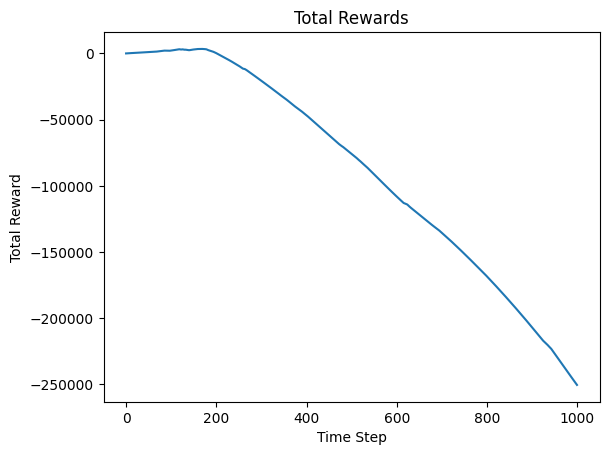

In [29]:
# Plot total rewards
plt.plot(total_rewards_mean.cumsum()) #, bins=20, color='skyblue', edgecolor='black')
plt.title("Total Rewards")
plt.xlabel("Time Step")
plt.ylabel("Total Reward")
plt.show()